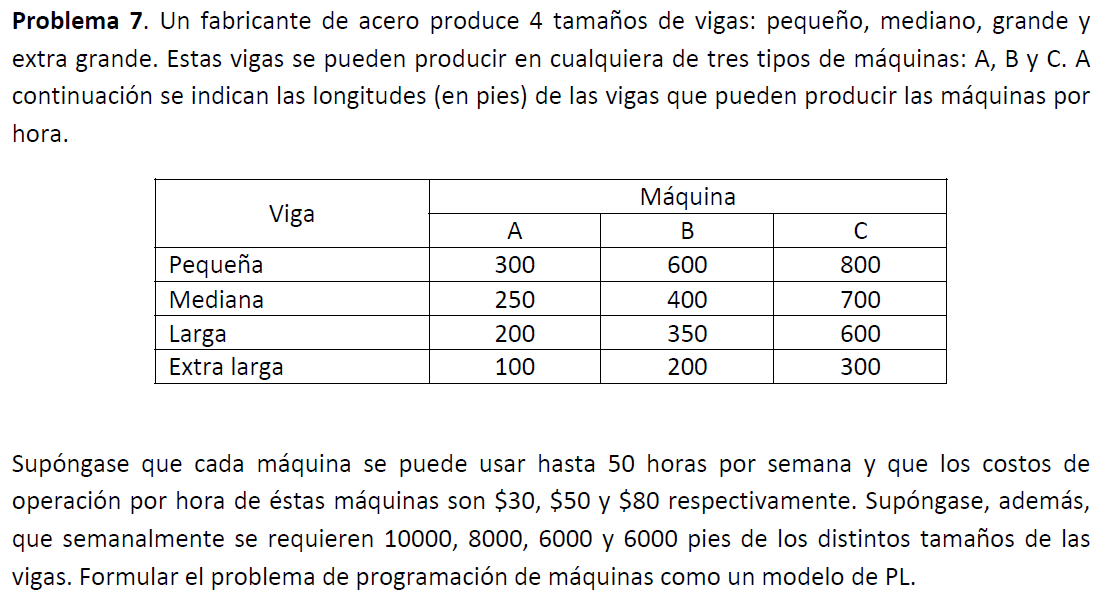

## Sets
I es el conjunto de vigas (i = 1 es pequeña, i = 2 es mediana, i = 3 es larga, i = 4 es extralarga)\
J es el conjunto de máquinas (j = 1 es A, j = 2 es B, j = 3 es C)

In [18]:
import pyomo.environ as pe
import pyomo.opt as po

In [19]:
model = pe.ConcreteModel()

In [20]:
model.I = pe.RangeSet(1,4)
model.J = pe.RangeSet(1,3)

## Parameters
Demi es la demanda semanal de la cantidad de pies de la viga i (pies)\
Cosj es el costo de operación por hora en la máquina j (dolar/hora)\
TDj es el tiempo disponible de operación semanal por la máquina j (hora/semana)\
Longij es la longitud en pies de la viga i producido por la máquina j por hora (pies/hora)

In [21]:
Dem = {1: 10000, 2: 8000, 3: 6000, 4: 6000}
Cos = {1: 30, 2: 50, 3: 80}
TD = {1: 50, 2: 50, 3: 50}
Long = {(1,1): 300,   (1,2): 600,    (1,3): 800, 
        (2,1): 250,   (2,2): 400,    (2,3): 700,
        (3,1): 200,   (3,2): 350,    (3,3): 600,
        (4,1): 100,   (4,2): 200,    (4,3): 300}

In [22]:
model.Dem = pe.Param(model.I, initialize = Dem) #Demanda semanal
model.Cos = pe.Param(model.J, initialize = Cos) #Costo de operación
model.TD = pe.Param(model.J, initialize = TD) #Tiempo disponible
model.Long = pe.Param(model.I, model.J, initialize = Long) #Longitud

## Variables
xij es la cantidad de pies por semana de la viga i producidos en la máquina j

In [23]:
model.x = pe.Var(model.I, model.J, domain = pe.NonNegativeReals)

## Objective

In [24]:
Z = sum(model.Cos[j] * (model.x[i,j] / model.Long[i,j])
        for i in model.I for j in model.J)
model.objective = pe.Objective(sense = pe.minimize, expr = Z)
model.objective.pprint()

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 0.1*x[1,1] + 0.08333333333333334*x[1,2] + 0.1*x[1,3] + 0.12*x[2,1] + 0.125*x[2,2] + 0.11428571428571428*x[2,3] + 0.15*x[3,1] + 0.14285714285714285*x[3,2] + 0.13333333333333333*x[3,3] + 0.3*x[4,1] + 0.25*x[4,2] + 0.26666666666666666*x[4,3]


## Constraints

In [25]:
#Tiempo disponible
model.Tdispon = pe.ConstraintList()
for j in model.J:
    Tdispon_lhs = sum((model.x[i,j] / model.Long[i,j]) for i in model.I)
    Tdispon_rhs = model.TD[j]
    model.Tdispon.add(Tdispon_lhs <= Tdispon_rhs)
model.Tdispon.pprint()

Tdispon : Size=3, Index=Tdispon_index, Active=True
    Key : Lower : Body                                                                                                        : Upper : Active
      1 :  -Inf :                                    0.0033333333333333335*x[1,1] + 0.004*x[2,1] + 0.005*x[3,1] + 0.01*x[4,1] :  50.0 :   True
      2 :  -Inf :                   0.0016666666666666668*x[1,2] + 0.0025*x[2,2] + 0.002857142857142857*x[3,2] + 0.005*x[4,2] :  50.0 :   True
      3 :  -Inf : 0.00125*x[1,3] + 0.0014285714285714286*x[2,3] + 0.0016666666666666668*x[3,3] + 0.0033333333333333335*x[4,3] :  50.0 :   True


In [26]:
#Demanda
model.Demanda = pe.ConstraintList()
for i in model.I:
    Demanda_lhs = sum(model.x[i,j] for j in model.J)
    Demanda_rhs = model.Dem[i]
    model.Demanda.add(Demanda_lhs >= Demanda_rhs)
model.Demanda.pprint()

Demanda : Size=4, Index=Demanda_index, Active=True
    Key : Lower   : Body                     : Upper : Active
      1 : 10000.0 : x[1,1] + x[1,2] + x[1,3] :  +Inf :   True
      2 :  8000.0 : x[2,1] + x[2,2] + x[2,3] :  +Inf :   True
      3 :  6000.0 : x[3,1] + x[3,2] + x[3,3] :  +Inf :   True
      4 :  6000.0 : x[4,1] + x[4,2] + x[4,3] :  +Inf :   True


## Solver

In [27]:
solver = po.SolverFactory('glpk')
results = solver.solve(model, tee = True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp2sxo7rcc.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpf3oy4sch.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp1nam5bwf.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp1nam5bwf.pyomo.lp'...
8 rows, 13 columns, 25 non-zeros
81 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpf3oy4sch.glpk.glp'...
69 lines were written
GLPK Simplex Optimizer 5.0
8 rows, 13 columns, 25 non-zeros
Preprocessing...
7 rows, 12 columns, 24 non-zeros
Scaling...
 A: min|aij| =  1.250e-03  max|aij| =  1.000e+00  ratio =  8.000e+02
GM: min|aij| =  9.326e-01  max|aij| =  1.072e+00  ratio =  1.150e+00
EQ: min|aij| =  8.878e-01  max|aij| =  1.000e+00  ratio =  1.126e+00
Constructing initial basis...
Size of triangular part is 7
      0: obj =   0.000000000e+00 inf =   2.694e+04 (4)
      4: obj =

In [28]:
for i in model.I:
    for j in model.J:
        print(pe.value(model.x[i,j]))
print(pe.value(model.objective))

0.0
10000.0
0.0
0.0
0.0
8000.0
0.0
0.0
6000.0
0.0
6000.0
0.0
4047.6190476190477
